In [2]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib as mpl
import pandas as pd
import xml.etree.ElementTree as ET, urllib.request, gzip, io

mpl.rcParams['axes.labelsize'] = 20
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16
mpl.rcParams['axes.titlesize'] = 20
# import seaborn as sns
%matplotlib inline

# Nice looking Seaborn settings for notebooks
# rc = {'lines.linewidth': 2, 
#       'axes.labelsize': 18, 
#       'axes.titlesize': 18, 
#       'axes.facecolor': 'DFDFE5'}
# sns.set_context('notebook', rc=rc)
# sns.set_style('darkgrid', rc=rc)

# Load data from catalogue

First, load the most up-to-date data on circumbinary exoplanets from the Open Exoplanet Catalogue.

In [3]:
# Link to OEC
url = "https://github.com/OpenExoplanetCatalogue/oec_gzip/raw/master/systems.xml.gz"
# Load XML tree into memory
oec = ET.parse(gzip.GzipFile(fileobj=io.BytesIO(urllib.request.urlopen(url).read())))
print(type(oec))

<class 'xml.etree.ElementTree.ElementTree'>


In [4]:
# Find all circumbinary planets (i.e., children of <binary> tag)
print("Total number of CBPs: ", len(oec.findall(".//binary/planet")), "\n")

for planet in oec.findall(".//binary/planet"): # note, "//" searches through all sublevels
    print(planet.findtext("name"), "-", planet.findtext("discoverymethod"))  

# Find all binary systems with multiple CBPs
print("\nSystems with multiple CBPs: \n")
for binary in oec.findall(".//binary"):
    n_p = len(binary.findall("./planet"))
    if n_p > 1:
        print(binary.findtext(".//name"),",", n_p,"planets")
               

# Store all CBPs in a pandas DataFrame object
columns = ['m', 'm_erru', 'm_errorl', 'R', 'a', 'P',
           'e', 'I', 'mstar1', 'mstar2', 'q', 'a_binary', 'P_binary', 'e_binary']
rows_transit = []
rows_timing = []

# Find all transit CBPs, i.e., MS CBPs detected by Kepler
for planet in oec.findall(".//binary/planet"): # note, "//" searches through all sublevels
    if (planet.findtext("discoverymethod")=="transit"):
        rows_transit.append(planet.findtext("name"))
        
# Find all ETV CBPs, i.e., PCE CBPs
for planet in oec.findall(".//binary/planet"): 
    if (planet.findtext("discoverymethod")=="timing"):
        rows_timing.append(planet.findtext("name"))   

# Create DataFrame object
planets_transit = pd.DataFrame(columns=columns, index=rows_transit)
planets_timing = pd.DataFrame(columns=columns, index=rows_timing)

# Iterate over each planet in binary systems, fill in the column data
for binary in oec.findall(".//binary"):
    # get masses of stars in binary
    mstars = [0, 0]
    for i, star in enumerate(binary.findall("./star")):
        # check if mass string is either empty or None
        if star.findtext("mass") is not None and star.findtext("mass"):
            mstars[i] = float(star.findtext("mass"))
    mstars.sort()
    
    # iterate over planets in binary
    for planet in binary.findall("./planet"):
        mass_errors = [0, 0]
        if planet.find("./mass") is not None:
            mass_errors[0] = planet.find("./mass").get('errorplus')
            mass_errors[1] = planet.find("./mass").get('errorminus')
            
        data = [
                planet.findtext("mass"),
                mass_errors[0],
                mass_errors[1],
                planet.findtext("radius"),
                planet.findtext("semimajoraxis"),
                planet.findtext("period"),
                planet.findtext("eccentricity"),
                planet.findtext("inclination"),
                mstars[0],
                mstars[1],
                mstars[0]/mstars[1],
                binary.findtext("semimajoraxis"),
                binary.findtext("period"),
                binary.findtext("eccentricity")
            ]
            
        if (planet.findtext("discoverymethod")=="transit"):
            planets_transit.loc[planet.findtext("name")] = data
            
        if (planet.findtext("discoverymethod")=="timing"):
            planets_timing.loc[planet.findtext("name")] = data
            
# Convert all values in DataFrame to floats
planets_transit = planets_transit.apply(pd.to_numeric, errors='raise')
planets_timing = planets_timing.apply(pd.to_numeric, errors='raise')

Total number of CBPs:  29 

2M 1938+4603 b - timing
DP Leo b - timing
FL Lyr b - timing
FW Tau b - imaging
HU Aqr (AB) b - timing
HU Aqr (AB) c - timing
HU Aqr (AB) d - timing
HW Vir (AB) b - timing
Kepler-1647 b - transit
Kepler-16 (AB) b - transit
Kepler-34 (AB) b - transit
Kepler-35 (AB) b - transit
Kepler-38 (AB) b - transit
Kepler-413 b - transit
Kepler-47 (AB) b - transit
Kepler-47 (AB) c - transit
KIC 9632895 b - transit
KOI-2939 b - transit
NN Ser (AB) c - timing
NN Ser (AB) d - timing
NSVS 14256825 c - timing
NSVS 14256825 d - timing
NY Virginis (AB) b - timing
PH-1 A(ab) b - transit
PSR B1620-26 b - timing
Ross 458 C - imaging
ROXs 42 B b - imaging
RR Cae (AB) b - timing
SR 12 C - imaging

Systems with multiple CBPs: 

HU Aqr , 3 planets
Kepler-47 , 2 planets
NN Ser A , 2 planets
NSVS 14256825 A , 2 planets


# Kepler circumbinary planets

In [5]:
planets_transit

,m,m_erru,m_errorl,R,a,P,e,I,mstar1,mstar2,q,a_binary,P_binary,e_binary
Kepler-1647 b,1.520000,0.650000,0.650000,1.060000,2.72050,1107.5923,0.05810,90.0972,0.97500,1.2100,0.805785,0.127600,11.258820,0.16020
Kepler-16 (AB) b,0.333000,NaN,NaN,0.753800,0.70480,228.7760,0.00685,90.0322,0.20255,0.6897,0.293678,0.220000,41.000000,NaN
Kepler-34 (AB) b,0.220000,NaN,NaN,0.764000,1.08960,288.8220,0.18200,90.3550,1.02080,1.0479,0.974139,0.115909,27.795800,0.52087
Kepler-35 (AB) b,0.127000,NaN,NaN,0.728000,0.60347,131.4580,0.04200,90.7600,0.81000,0.8900,0.910112,0.176170,20.733000,0.14210
Kepler-38 (AB) b,NaN,0.000000,0.000000,0.396417,0.46440,105.5950,0.03200,90.1820,0.24900,0.9490,0.262381,0.146000,NaN,0.10320
Kepler-413 b,0.210762,0.069205,0.069205,0.396143,NaN,66.2620,0.11800,4.0730,0.54230,0.8200,0.661341,0.101480,10.116146,0.03720
Kepler-47 (AB) b,NaN,0.000000,0.000000,0.271568,0.29560,49.5140,NaN,89.5900,0.36200,1.0430,0.347076,0.083600,7.448300,0.02340
Kepler-47 (AB) c,NaN,0.000000,0.000000,0.420111,0.98900,303.1580,NaN,89.8260,0.36200,1.0430,0.347076,0.083600,7.448300,0.02340
KIC 9632895 b,0.019503,0.050331,0.050331,0.561818,0.78770,240.5030,0.03790,89.4338,0.19380,0.9340,0.207495,0.184790,27.322037,0.05100
KOI-2939 b,1.520000,0.648000,0.648000,1.059320,2.72050,1107.5923,0.05810,90.0972,0.96780,1.2207,0.792824,0.127600,11.258818,0.16020


## Binary data

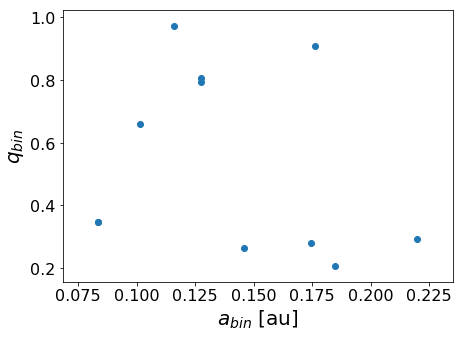

In [6]:
# Binary mass ratio q, s.t. q < 1

fig, ax = plt.subplots(figsize=(7,5))
ax.scatter(planets_transit['a_binary'].values, planets_transit['q'].values)
ax.set_xlabel(r'$a_{bin}$ [au]')
ax.set_ylabel(r'$q_{bin}$')

## Planet data

array([ 98.37552248,   5.57990244,  10.39085042,   6.34051994,
                nan,   6.55012294,   6.64769142,  40.70163662,
         8.80252816,  98.37554083,   6.9252259 ])

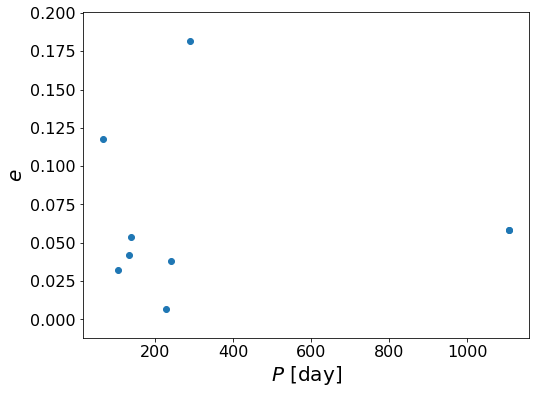

In [7]:
fig, ax = plt.subplots(figsize=(8,6))
ax.scatter(planets_transit['P'].values, planets_transit['e'].values);
ax.set_xlabel(r'$P$ [day]')
ax.set_ylabel(r'$e$')

planets_transit['P'].values/planets_transit['P_binary'].values

Make plots from Kostov's talk and a 2D color plot of M1 vs M2 of binary evolution outcomes, repeat for different MS binary periods and other important parameters (plot is symmetric about M1=M2).

Make also a plot from Hagai Perets's paper, showing newly available regions of phase space. Also, make a plot or table entry from Holman and Wiegert critical semi-major axis.

# Resonance widths
Following the very general disturbing function expansion in spherical harmonics (R. Mardling 2013), one can derive analytic expressions for the width of $n:1$ resonances with the inner body. The rate of change of a general harmonic angle $\Phi_{mnn'}$ in the disturbing function expansion is given by

$$\dot{\Phi}_{mnn'}=n\nu_i-n'\nu_o+n\dot{\epsilon}_i-n'\dot{\epsilon}_o+(m-n)
\dot{\varpi}_i-(m-n')\dot{\varpi}_o$$

where $\epsilon_i$ is the mean longitude at epoch, $\nu_i$ is the orbital frequency of the inner binary(stellar binary) and $\nu_o$ is the orbital frequency of the outer binary(planet around inner binary CM). Except for systems with very small eccentricities $\dot{\varpi}_i\ll \nu_o$ and $\dot{\varpi}_o\ll \nu_o$. For all systems, 
$\dot{\epsilon}_i\ll \nu_o$ and $\dot{\epsilon}_o\ll \nu_o$. Thus, $\dot{\Phi}_{mnn'}$ for the case of an $n:1$
resonance is approximately equal to

$$\dot{\Phi}_{m12}\approx \nu_i-n\nu_o$$

Libration occurs if this angle is approx zero. The question one can ask then is how close to exact commensurability should a system be in order for this angle to librate. This defines the width of the resonance. The answer can be obtained by showing that $\Phi_{m12}$ approximately satisfies the pendulum equation for the case $m=2$ (
expansion to quadrupole order). We have

$$\ddot{\Phi}_{21n}\equiv \ddot{\Phi}_n=\dot{\nu}_i-n\dot{\nu}_o=-\frac{3}{2}\nu_o
\left(\sigma\frac{\dot{a}_i}{a_i}-n\frac{\dot{a}_o}{a_o}\right)$$

where $\sigma=\nu_i/\nu_o$. We can then use \emph{Lagrange's planetary equations} to derive expressions for the time derivatives of $a$-s in terms of the derivatives of the disturbing function to quadrupole order, however, we need to neglect all terms in $\mathcal{R}$ except the one corresponding to the $n:1$ resonance. The resulting resonance width is then given by 

$$\Delta\sigma_n= \frac{6\mathcal{H}_{22}^{1/2}}{(2\pi)^{1/4}} \left[ \left( \frac{m_3}{m_{123}}  \right) +n^{2/3} \left( \frac{m_{12}}{m_{123}} \right)^{2/3} \left( \frac{m_1m_2}{m_{12}^2}  \right)\right]^{1/2} \left( \frac{e_i^{1/2}}{e_o}  \right)\left(1- \frac{13}{24} e_i^2\right)^{1/2}(1-e_o^2)^{3/8}n^{3/4}e^{-n\xi(e_o)/2}$$

where

$$\sigma=\frac{\nu_i}{\nu_o}\simeq n/n',\;\;\;\mathcal{H}_{22}=0.71,\;\;\;\xi(e_o)=\cosh^{-1}(1/e_o)-\sqrt{1-e_o^2}$$

The resonance widths depend on 8 parameters: $m_2/m_1,\;m_3/m_{12},\;\sigma \; ,\;e_i, \;e_0,\; \varpi_i-\varpi_o,\; M_i(0),\;M_o(0)$. We fixed $\varpi_i-\varpi_o=M_i(0)=0$ and $M_o=-\pi$. 

/home/fran/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:4: RuntimeWarning: divide by zero encountered in true_divide
/home/fran/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:5: RuntimeWarning: divide by zero encountered in true_divide
/home/fran/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in multiply


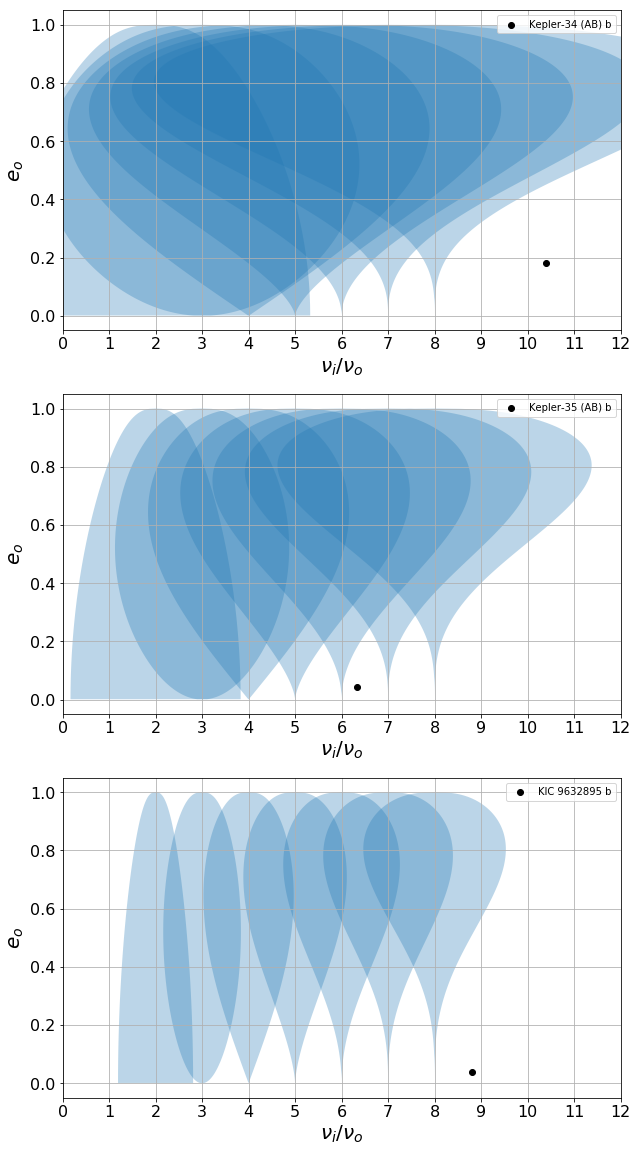

In [63]:
def resonance_width(m1, m2, m3, n, e_i, e_o):
    m123 = m1 + m2 + m3
    m12 = m1 + m2
    xi = np.arccosh(1/e_o) - np.sqrt(1 - e_o**2)
    width = (6*0.71**.5/((2*np.pi)**(1/4.)))*\
            (m3/m123 + n**(2/3.) *(m12/m123)**(2/3.)*(m1*m2/m12**2))**.5 *\
            (e_i**.5/e_o)*(1 - 13/24.*e_i**2.)**.5*(1 - e_o**2)**(3/8.)*\
            n**(3/4.)*np.exp(-n*xi/2.);
    return width

def plot_resonances(ax, m1, m2, m3, e_i, e, P_i, P_o, name):
    e_o = np.linspace(0, 1, 1000) 
    
    for n in range(2, 9):
        width = resonance_width(m1, m2, m3, n, e_i, e_o)
        ax.fill_betweenx(e_o, -width + n, width + n, facecolor='C0', alpha=0.3)
        
    ax.grid(True)
    ax.set_xlim(0, 12)
    ax.set_xlabel(r'$\nu_i/\nu_o$')
    ax.set_ylabel(r'$e_o$')
    ax.set_xticks(np.arange(0, 13))   
    ax.scatter(P_o/P_i, e, color='black', label=name)
    ax.legend()

# Kepler planets with suffiecient data
planets = ['Kepler-34 (AB) b', 'Kepler-35 (AB) b', 'KIC 9632895 b']

fig, ax = plt.subplots(len(planets), 1, figsize=(10, 20))

for i, planet in enumerate(planets):
    m1 = planets_transit.loc[planet, 'mstar1']
    m2 = planets_transit.loc[planet, 'mstar2']
    m3 = planets_transit.loc[planet, 'm']
    e_i = planets_transit.loc[planet, 'e_binary']
    P_i = planets_transit.loc[planet, 'P_binary']
    P_o = planets_transit.loc[planet, 'P']
    e = planets_transit.loc[planet, 'e']
    plot_resonances(ax[i], m1, m2, m3, e_i, e, P_i, P_o, planet)

In [62]:
planets_timing

,m,m_erru,m_errorl,R,a,P,e,I,mstar1,mstar2,q,a_binary,P_binary,e_binary
2M 1938+4603 b,1.900,0.10,0.10,NaN,0.920,416.0000,NaN,NaN,0.120,0.480,0.250000,0.004140,0.125765,NaN
DP Leo b,6.050,NaN,NaN,NaN,8.190,10230.0000,0.3900,NaN,0.090,0.600,0.150000,NaN,0.062500,NaN
FL Lyr b,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.963,1.218,0.790640,NaN,2.178154,NaN
HU Aqr (AB) b,4.758,NaN,NaN,NaN,3.602,NaN,0.0218,90.0,0.180,0.800,0.225000,NaN,0.868204,NaN
HU Aqr (AB) c,20.200,NaN,NaN,NaN,6.557,NaN,0.1365,90.0,0.180,0.800,0.225000,NaN,0.868204,NaN
HU Aqr (AB) d,80.000,NaN,NaN,NaN,12.887,NaN,0.0158,90.0,0.180,0.800,0.225000,NaN,0.868204,NaN
HW Vir (AB) b,14.300,NaN,NaN,NaN,4.690,4640.0000,0.4000,NaN,0.142,0.485,0.292784,0.003998,0.116700,NaN
NN Ser (AB) c,6.960,0.12,0.12,NaN,5.389,5654.6797,0.1420,NaN,0.111,0.535,0.207477,NaN,0.133333,NaN
NN Ser (AB) d,1.740,0.09,0.09,NaN,3.358,2793.0000,0.2230,NaN,0.111,0.535,0.207477,NaN,0.133333,NaN
NSVS 14256825 c,2.800,NaN,NaN,NaN,1.900,1276.0000,0.0000,NaN,0.109,0.419,0.260143,NaN,0.110342,NaN
